# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: Aur Marina Iuliana

**Matricola**: 1809715

> ✍ Upload the completed notebook **before 20/11/2023 at 23:59** on the Google Classroom page.

In [59]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np

In [60]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

## Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

The dataset used in the homework is the "Cats vs Dogs", a dataset provided by TensorFlow Datasets. It comprises a set of images with corresponding labels and the final goal is to conduct binary classification between cats and dogs.

*Source*: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

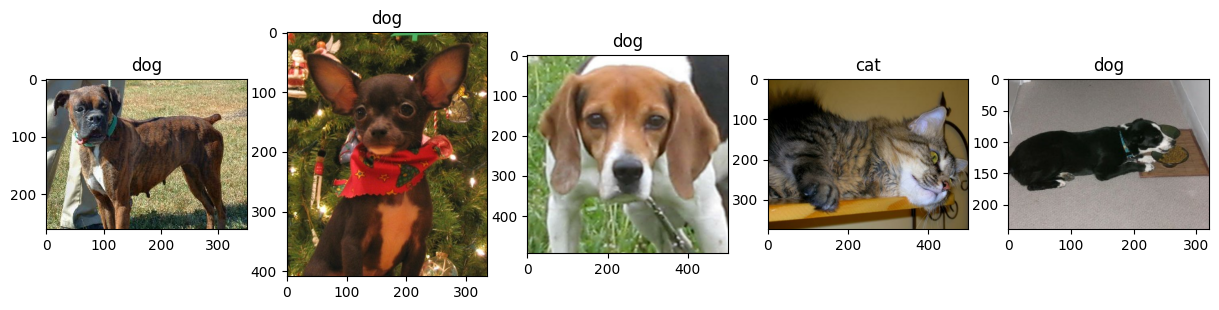

In [61]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

# The dataset has been splitted into three parts: 70% for training, 20% for validation and 10% for testing,
# ensuring a balanced distribution for effective model training
train_data, val_data, test_data = tfds.load('cats_vs_dogs', as_supervised = True, split = ['train[0:70%]', 'train[70%:90%]', 'train[90%:]'])

# Dataset Preview
first_5_elements = train_data.take(5)
plt.figure(figsize=(15, 10))

for i,sample in enumerate(first_5_elements, 1):
  X, y = sample
  plt.subplot(1, 5, i)
  plt.imshow(X)
  plt.title('cat' if y == 0 else 'dog')

plt.show()

In [62]:
# Preprocessing to standardize sizes
def preprocess(image, label):
    image = tf.image.resize(image, [128, 128])
    return image / 255.0, label

# Augment filter to improve overall performance
def augment(image, label):
  image = tf.image.random_brightness(image, 0.1)
  return image, label

# Set up
train_data_norm = train_data.shuffle(1000).map(augment).map(preprocess).batch(32)
val_data_norm = val_data.map(preprocess).batch(32)
test_data_norm = test_data.map(preprocess).batch(32)

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

In [63]:
# TODO: define a suitable neural network.

def add_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    return layers.MaxPool2D(2)(x)

def build_model():
  inp = layers.Input(shape=(128, 128, 3))
  # Convolutive part
  x = add_conv_block(inp, 32)
  x = add_conv_block(x, 64)
  x = add_conv_block(x, 64)
  x = add_conv_block(x, 128)
  x = add_conv_block(x, 128)
  # Global average pooling
  x = layers.GlobalAvgPool2D()(x)
  # Classification block
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dense(128, activation='relu')(x)
  # Binary Classification
  x = layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs=inp, outputs=x)

model = build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization_15 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_15 (TFOpLambda)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        5126

In [64]:
# TODO: train the neural network.
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.fit(train_data_norm, validation_data=val_data_norm, epochs=10)

Epoch 1/10
509/509 [==============================] - 45s 80ms/step - loss: 0.6300 - accuracy: 0.6432 - val_loss: 0.7001 - val_accuracy: 0.5811
Epoch 2/10
509/509 [==============================] - 41s 79ms/step - loss: 0.5107 - accuracy: 0.7494 - val_loss: 0.6895 - val_accuracy: 0.5979
Epoch 3/10
509/509 [==============================] - 42s 80ms/step - loss: 0.4050 - accuracy: 0.8167 - val_loss: 0.5003 - val_accuracy: 0.7584
Epoch 4/10
509/509 [==============================] - 45s 88ms/step - loss: 0.3302 - accuracy: 0.8591 - val_loss: 1.2052 - val_accuracy: 0.5227
Epoch 5/10
509/509 [==============================] - 41s 79ms/step - loss: 0.2719 - accuracy: 0.8836 - val_loss: 0.3417 - val_accuracy: 0.8517
Epoch 6/10
509/509 [==============================] - 46s 88ms/step - loss: 0.2303 - accuracy: 0.9020 - val_loss: 0.3184 - val_accuracy: 0.8625
Epoch 7/10
509/509 [==============================] - 42s 82ms/step - loss: 0.2006 - accuracy: 0.9188 - val_loss: 0.2853 - val_accuracy:

In [65]:
# TODO: test the neural network and print the result on screen.)
predictions = model.predict(test_data_norm)
loss, accuracy = model.evaluate(test_data_norm)

print("\nPredictions:\n", predictions)
print("\nTest accuracy:", round(accuracy, 3))

73/73 [==============================] - 3s 35ms/step - loss: 0.3430 - accuracy: 0.8766

Predictions:
 [[8.6481747e-04]
 [9.7340935e-01]
 [9.9892032e-01]
 ...
 [5.9808946e-01]
 [9.9966633e-01]
 [4.0547675e-03]]

Test accuracy: 0.877


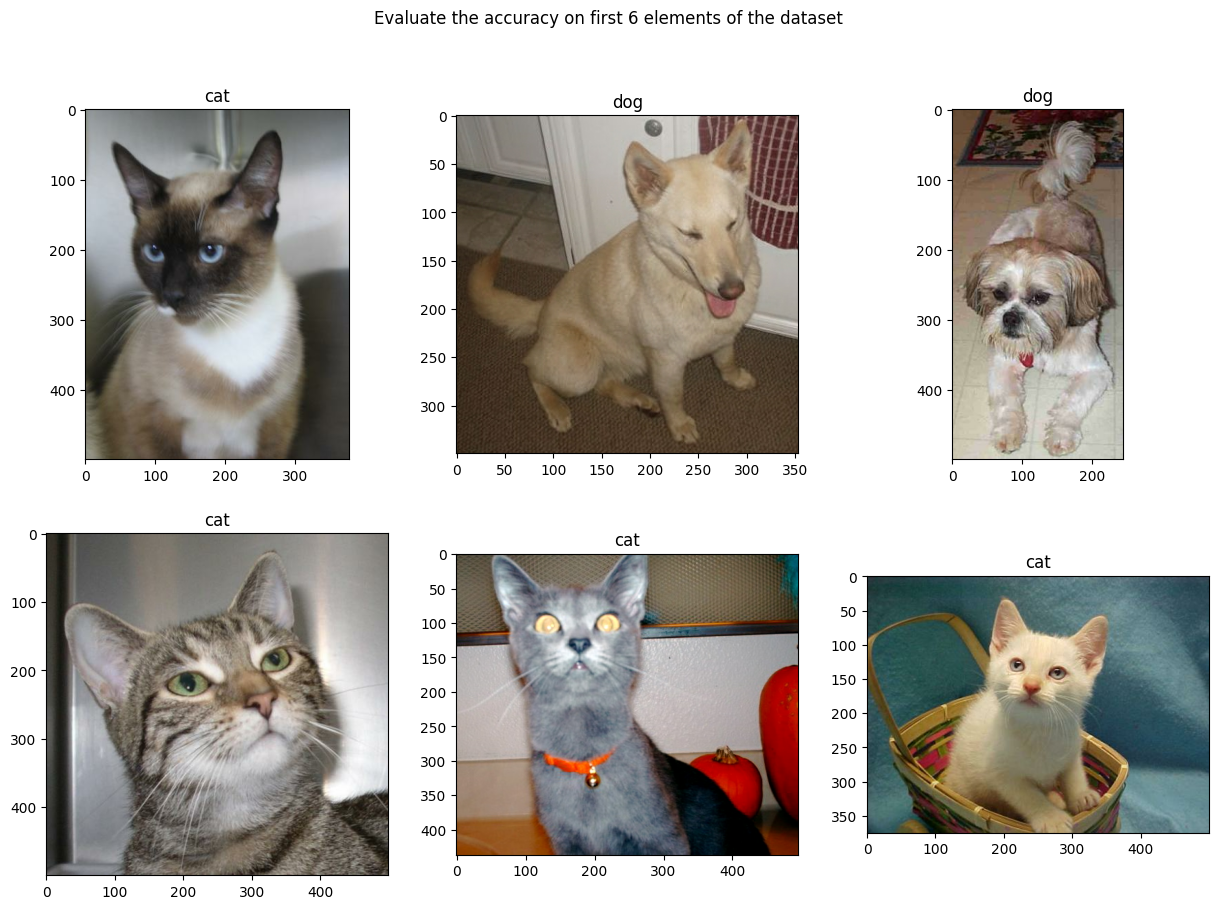

In [66]:
# Accuracy preview

first_6_elements = test_data.take(6)
plt.figure(figsize=(15, 10))

for i, sample in enumerate(first_6_elements, 1):
    X, y = sample
    plt.subplot(2, 3, i)
    plt.imshow(X)
    plt.title('dog' if predictions[i - 1] >= 0.5 else 'cat')

plt.suptitle("Evaluate the accuracy on first 6 elements of the dataset")
plt.show()

### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

In [67]:
# TODO: Take an element from your test set and compute the saliency map

def compute_saliency_map(model, image, label):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.binary_crossentropy(label, prediction)

  gradient = tape.gradient(loss, image) # compute gradient
  saliency_map = tf.abs(gradient) # compute abs
  norm_saliency_map = tf.reduce_sum(saliency_map, axis = -1) # normalize saliency map
  norm_saliency_map = tf.squeeze(norm_saliency_map) # squeeze out unecessary dimension
  return norm_saliency_map

In [68]:
# Take an element from test set
images_batch, labels_batch = next(iter(test_data_norm))

single_image = images_batch[0]
single_label = labels_batch[0]

single_image = tf.expand_dims(single_image, axis=0)
single_label = tf.reshape(single_label, (-1, 1))

# Compute the saliency map
vanilla_saliency_map = compute_saliency_map(model, single_image, single_label)

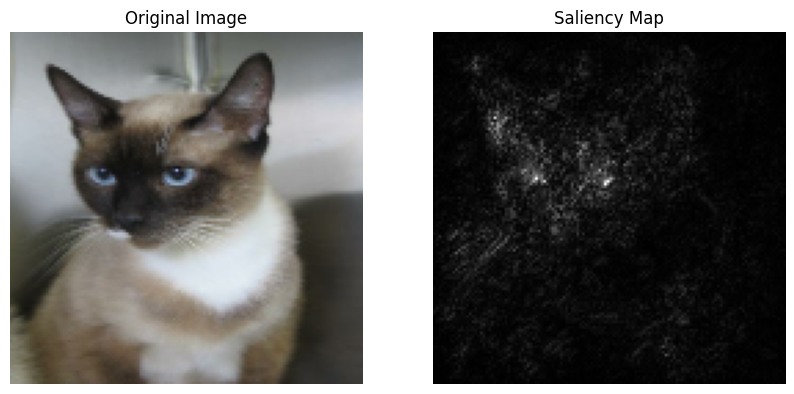

In [69]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(single_image))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(vanilla_saliency_map, cmap='gray')
plt.title("Saliency Map")
plt.axis('off')
plt.show()

In this example, we can easily separate the cat from the background because the cat is the main focus. The saliency map successfully highlights the prominent points, that are the edges related to the cat and their surrounding area. Nevertheless, the edges **lack sharpness** and there is some **noise** present in the image.

### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


In [70]:
# TODO: Take an element from your test set and compute SmoothGrad. Check the results and compare with respect to the previous exercise.

def compute_smooth_gradient(model, image, label, n, noise_level):
  smooth_grad = []
  for i in range(n):
    noise = tf.random.normal(shape = tf.shape(image), mean = 0.0, stddev = noise_level)
    smooth_input = image + noise

    with tf.GradientTape() as tape:
      tape.watch(smooth_input)
      y_pred = model(smooth_input)
      loss = tf.keras.losses.binary_crossentropy(label, y_pred)

    gradients = tape.gradient(loss, smooth_input)
    smooth_grad.append(gradients)

  avg_smooth_grad = tf.reduce_mean(smooth_grad, axis = 0) # compute mean
  avg_smooth_grad_norm = tf.reduce_sum(avg_smooth_grad, axis=-1) # normalize the smoothgrad
  avg_smooth_grad_norm = tf.squeeze(avg_smooth_grad_norm) # squeeze out unecessary dimension
  return avg_smooth_grad_norm

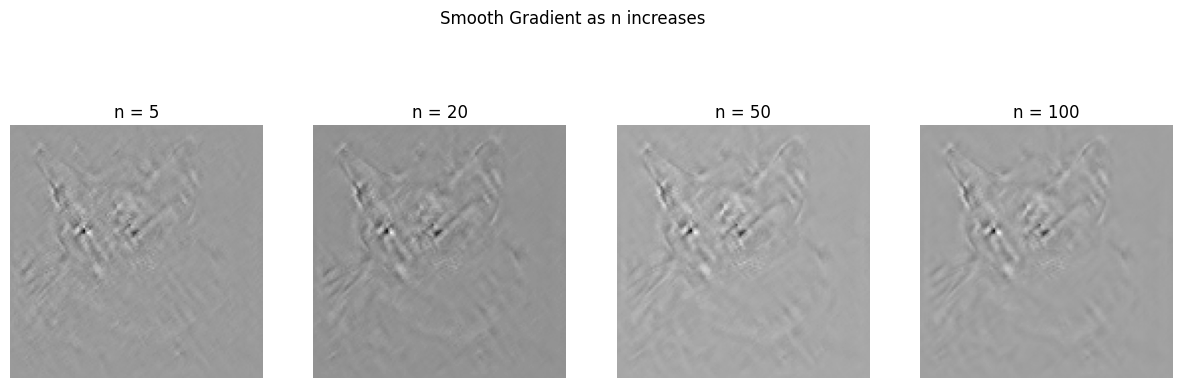

In [71]:
# Take an element from your test set and compute SmoothGrad
sample_size = [5, 20, 50, 100]
fig, axes = plt.subplots(1, len(sample_size), figsize=(15, 5))

for i, n in enumerate(sample_size):
    smooth_grad = compute_smooth_gradient(model, single_image, single_label, n, 0.1)
    axes[i].imshow(smooth_grad, cmap='gray')
    axes[i].set_title(f'n = {n}')
    axes[i].axis('off')

plt.suptitle('Smooth Gradient as n increases')
plt.show()

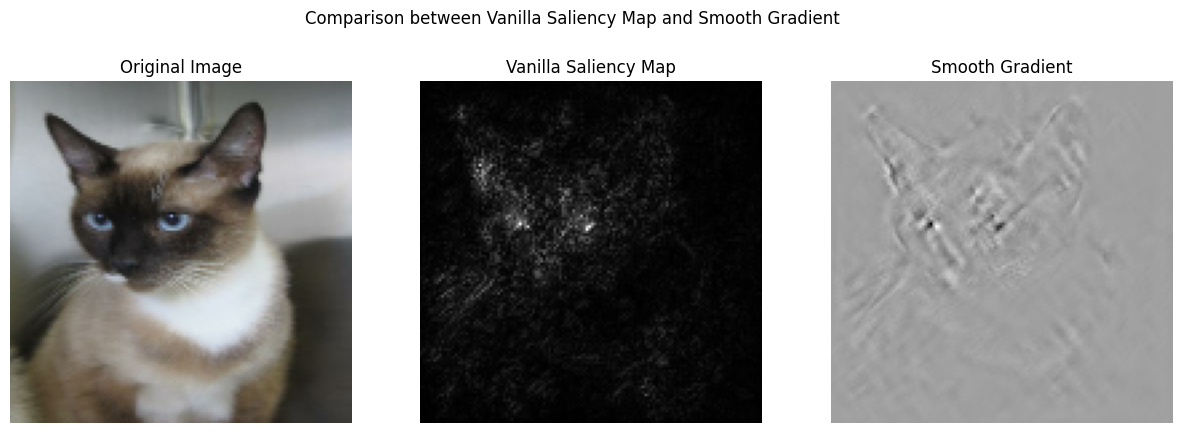

In [72]:
#Check the results and compare with respect to the previous exercise
smooth_grad = compute_smooth_gradient(model, single_image, single_label, 50, 0.1) # n = 50 is commonly used in literature

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(single_image))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(vanilla_saliency_map, cmap='gray')
plt.title("Vanilla Saliency Map")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(smooth_grad, cmap='gray')
plt.title("Smooth Gradient")
plt.axis('off')

plt.suptitle('Comparison between Vanilla Saliency Map and Smooth Gradient')
plt.show()

By employing SmoothGrad, we can see a notable enhancement in the saliency map: the edges are considerably **more precise and continuous** and there is a reduction in **overall noise**.

### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

In [73]:
# TODO: Write the required function, possibly avoding for-loops.

def compute_parallel_saliency_maps(model, images, labels):
  with tf.GradientTape() as tape:
    tape.watch(images)
    predictions = model(images)
    loss = tf.keras.losses.binary_crossentropy(labels, predictions)

    gradients = tape.gradient(loss, images) # compute gradients
    return gradients

In [74]:
saliency_maps_batches = []
labels_matrix = []
for images_batch, labels_batch in test_data_norm:
  labels_batch = tf.reshape(labels_batch, (-1, 1))
  saliency_maps_batch = compute_parallel_saliency_maps(model, images_batch, labels_batch)
  saliency_maps_batches.append(saliency_maps_batch)
  labels_matrix.append(labels_batch)

**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

In [75]:
# TODO: Write the required function.

def compute_global_saliency_per_class(model, saliency_maps):
  avg_saliency_class = tf.reduce_mean(saliency_maps, axis = 0) # compute mean
  avg_saliency_class_norm = tf.reduce_sum(avg_saliency_class, axis=-1) # normalize the result

  return avg_saliency_class_norm

In [76]:
saliency_maps_label_0 = []
saliency_maps_label_1 = []

for saliency_maps_batch, labels_batch in zip(saliency_maps_batches, labels_matrix):
    for saliency_map, label in zip(saliency_maps_batch, labels_batch):
        if label == 0:
            saliency_maps_label_0.append(saliency_map)
        else:
            saliency_maps_label_1.append(saliency_map)

global_saliency_class_0_norm = compute_global_saliency_per_class(model, saliency_maps_label_0)
global_saliency_class_1_norm = compute_global_saliency_per_class(model, saliency_maps_label_1)

In [77]:
global_saliency_maps = saliency_maps_label_0 + saliency_maps_label_1
global_saliency_map_class_0_and_1 = compute_global_saliency_per_class(model, global_saliency_maps)

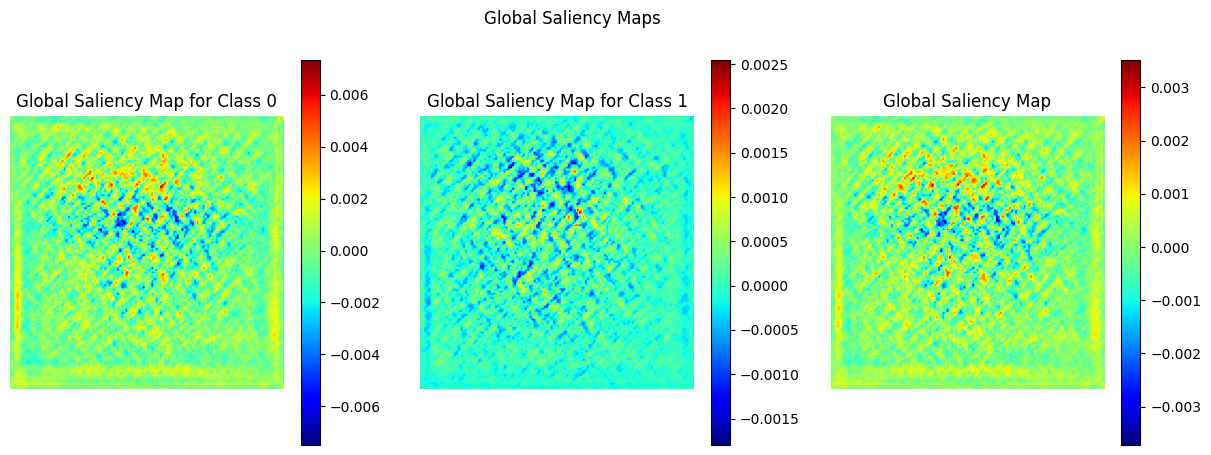

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(global_saliency_class_0_norm, cmap = 'jet')
plt.title('Global Saliency Map for Class 0')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(global_saliency_class_1_norm, cmap = 'jet')
plt.title('Global Saliency Map for Class 1')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(global_saliency_map_class_0_and_1, cmap = 'jet')
plt.title('Global Saliency Map')
plt.colorbar()
plt.axis('off')

plt.suptitle('Global Saliency Maps')
plt.show()

We can observe that there are few consistent patterns within each class and it is challenging to achieve a valid generalization of classes. This challenges likely arises from the presence of numerous images featuring elements in **different positions and sizes**.

By analyzing saliency maps, we obtain insights into the factors influencing the model's decision-making: it is evident that the **central pixels**, likely containing the subject of the image (a dog or a cat in our scenario), play a more substantial role in influencing the prediction, while the pixels in the background contribute less significantly.

**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [79]:
# TODO: Compare the results you obtained before with a simpler linear model.

linear_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(units=1, activation='sigmoid', use_bias=True)])

linear_model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_14 (Dense)            (None, 1)                 49153     
                                                                 
Total params: 49153 (192.00 KB)
Trainable params: 49153 (192.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
linear_model.fit(train_data_norm, validation_data=val_data_norm, epochs=10)

Epoch 1/10
509/509 [==============================] - 35s 67ms/step - loss: 1.0071 - accuracy: 0.5425 - val_loss: 1.2214 - val_accuracy: 0.5096
Epoch 2/10
509/509 [==============================] - 36s 70ms/step - loss: 1.0087 - accuracy: 0.5603 - val_loss: 0.8128 - val_accuracy: 0.5412
Epoch 3/10
509/509 [==============================] - 36s 70ms/step - loss: 1.0224 - accuracy: 0.5684 - val_loss: 0.7750 - val_accuracy: 0.5983
Epoch 4/10
509/509 [==============================] - 35s 66ms/step - loss: 0.9128 - accuracy: 0.5820 - val_loss: 0.9421 - val_accuracy: 0.5730
Epoch 5/10
509/509 [==============================] - 35s 68ms/step - loss: 0.8997 - accuracy: 0.5931 - val_loss: 1.3380 - val_accuracy: 0.5194
Epoch 6/10
509/509 [==============================] - 36s 69ms/step - loss: 0.8531 - accuracy: 0.6029 - val_loss: 0.9480 - val_accuracy: 0.5513
Epoch 7/10
509/509 [==============================] - 37s 71ms/step - loss: 0.8964 - accuracy: 0.5978 - val_loss: 0.7765 - val_accuracy:

In [81]:
predictions_2 = linear_model.predict(test_data_norm)
loss_2, accuracy_2 = linear_model.evaluate(test_data_norm)

print("\nPredictions:\n", predictions_2)
print("\nTest accuracy:", round(accuracy_2, 3))

73/73 [==============================] - 2s 28ms/step - loss: 1.1542 - accuracy: 0.5365

Predictions:
 [[0.11936017]
 [0.08617564]
 [0.02562566]
 ...
 [0.07508005]
 [0.08077653]
 [0.09718995]]

Test accuracy: 0.537


In [82]:
weights = linear_model.layers[1].get_weights()[0]
weights

array([[0.02603055],
       [0.03120313],
       [0.03114909],
       ...,
       [0.01223498],
       [0.00722597],
       [0.00400983]], dtype=float32)

In [83]:
weights = linear_model.layers[1].get_weights()[0]
weights_reshaped = np.reshape(weights, (128, 128, 3))
weights_normalized = (weights_reshaped - np.min(weights_reshaped)) / (np.max(weights_reshaped) - np.min(weights_reshaped))

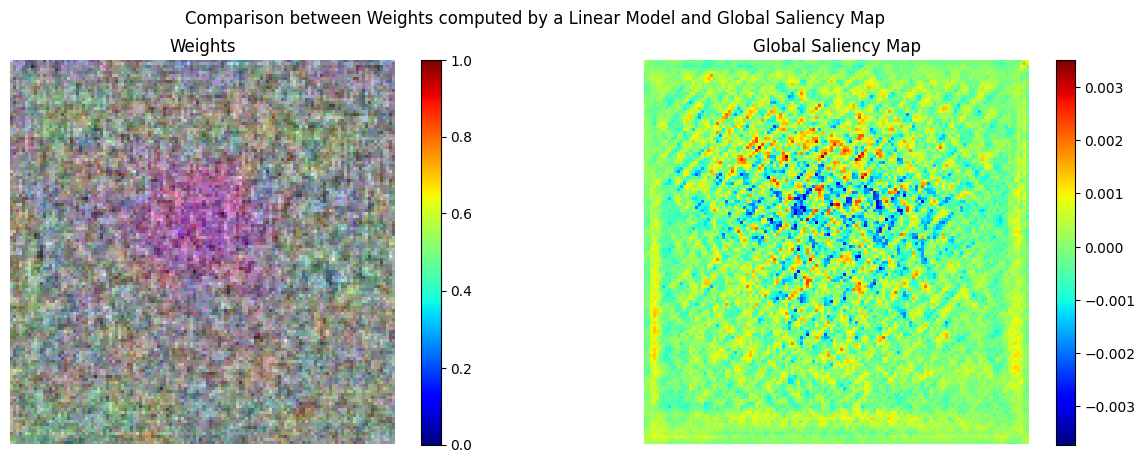

In [84]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(weights_normalized, cmap = 'jet')
plt.title('Weights')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(global_saliency_map_class_0_and_1, cmap = 'jet')
plt.title('Global Saliency Map')
plt.colorbar()
plt.axis('off')

plt.suptitle('Comparison between Weights computed by a Linear Model and Global Saliency Map')
plt.show()


In conclusion, when comparing the two techniques that identify which pixels are more crucial for the model's prediction, we again observe that central pixels are more influential than those in the background, confirming the prevalence of numerous images featuring the **subject in the foreground** in our dataset.










### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 20/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.